# 03 - Market Simulation, Bet Sizing & Evaluation

## 1. Paths, imports & settings

In [1]:
import json
import hashlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.6f}'.format
plt.rcParams['figure.figsize'] = (10,6)

PROJECT_DIR = path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parents[0]

DATA_DIR = PROJECT_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

OUTPUT_DIR = PROJECT_DIR / "outputs"
FIGURES_DIR = OUTPUT_DIR / "figures"
REPORTS_DIR = OUTPUT_DIR / "reports"

SCRIPTS_DIR = PROJECT_DIR/ "scripts"
NOTEBOOKS_DIR = PROJECT_DIR / "notebooks"

for p in [OUTPUT_DIR, FIGURES_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR.resolve())
print("RAW_DATA_DIR:", RAW_DATA_DIR.resolve())
print("OUTPUT_DIR:", OUTPUT_DIR.resolve())
print("PROJECT_DIR:", PROJECT_DIR.resolve())
print("RAW_DATA_DIR:", RAW_DATA_DIR.resolve())
print("OUTPUT_DIR:", OUTPUT_DIR.resolve())

PRESET_CONFIGS = {
    "conservative": {
        "INITIAL_BANKROLL": 1000.0,
        "STAKING": "kelly",    # still Kelly, but tiny fraction
        "FLAT_UNIT": 5.0,
        "KELLY_FRACTION": 0.10,
        "KELLY_CAP": 0.02,     # max 2% of bankroll
        "ALLOW_MULTI": False,
        "EV_THRESHOLD": 0.01,  # only bet when EV >= 1%
        "MAX_BETS_PER_MATCH": 1,
    },
    "balanced": {
        "INITIAL_BANKROLL": 1000.0,
        "STAKING": "kelly",
        "FLAT_UNIT": 5.0,
        "KELLY_FRACTION": 0.25,
        "KELLY_CAP": 0.05,     # max 5%
        "ALLOW_MULTI": False,
        "EV_THRESHOLD": 0.00,  # any positive EV
        "MAX_BETS_PER_MATCH": 1,
    },
    "aggressive": {
        "INITIAL_BANKROLL": 1000.0,
        "STAKING": "kelly",
        "FLAT_UNIT": 10.0,     # higher flat unit if you switch to flat
        "KELLY_FRACTION": 0.50,
        "KELLY_CAP": 0.10,     # max 10%
        "ALLOW_MULTI": True,   # can bet multiple sides in same match
        "EV_THRESHOLD": -0.01, # allow slightly negative (model “speculation”)
        "MAX_BETS_PER_MATCH": 3,
    },
}

# Choose a preset here: "conservative" / "balanced" / "aggressive"
STRATEGY = "balanced"

# Base defaults (can include things not in presets)
PARAMS = {
    "INITIAL_BANKROLL": 1000.0,
    "STAKING": "kelly",
    "FLAT_UNIT": 5.0,
    "KELLY_FRACTION": 0.25,
    "KELLY_CAP": 0.05,
    "ALLOW_MULTI": False,
    "EV_THRESHOLD": 0.00,
    "MAX_BETS_PER_MATCH": 1,
    "RANDOM_SEED": 42,
    "RUN_TAG": STRATEGY,   # tag figures/reports by strategy
}

PARAMS["GRID_EV_THRESHOLDS"] = list(np.round(np.linspace(0.00, 0.05, 6), 4))
PARAMS["GRID_KELLY_FRACS"] = [0.10, 0.25, 0.50]

# Apply preset overrides
if STRATEGY in PRESET_CONFIGS:
    PARAMS.update(PRESET_CONFIGS[STRATEGY])
else:
    print(f"Warning: STRATEGY '{STRATEGY}' not in PRESET_CONFIGS, using base PARAMS only.")

# Seed & show final config
np.random.seed(PARAMS["RANDOM_SEED"])
run_tag = PARAMS["RUN_TAG"] = STRATEGY  # keep RUN_TAG in sync with strategy

print("Using strategy:", STRATEGY)
print("PARAMS:")
for k, v in PARAMS.items():
    print(f"  {k}: {v}")

PROJECT_DIR: C:\Users\basti\Documents\football-betting
RAW_DATA_DIR: C:\Users\basti\Documents\football-betting\data\raw
OUTPUT_DIR: C:\Users\basti\Documents\football-betting\outputs
PROJECT_DIR: C:\Users\basti\Documents\football-betting
RAW_DATA_DIR: C:\Users\basti\Documents\football-betting\data\raw
OUTPUT_DIR: C:\Users\basti\Documents\football-betting\outputs
Using strategy: balanced
PARAMS:
  INITIAL_BANKROLL: 1000.0
  STAKING: kelly
  FLAT_UNIT: 5.0
  KELLY_FRACTION: 0.25
  KELLY_CAP: 0.05
  ALLOW_MULTI: False
  EV_THRESHOLD: 0.0
  MAX_BETS_PER_MATCH: 1
  RANDOM_SEED: 42
  RUN_TAG: balanced
  GRID_EV_THRESHOLDS: [np.float64(0.0), np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.05)]
  GRID_KELLY_FRACS: [0.1, 0.25, 0.5]


## 2. Load model probabilities & bookmaker odds

In [2]:
# Load csv file
E0_PATH = RAW_DATA_DIR / "E0.csv"
if not E0_PATH.exists():
    raise FileNotFoundError(f"Expected E0.csv at {E0_PATH}")

MODEL_PROBS_PATH = OUTPUT_DIR / "model_probabilities.csv"
if not MODEL_PROBS_PATH.exists():
    raise FileNotFoundError(f"Expected model_probabilities.csv at {MODEL_PROBS_PATH}")
    
raw = pd.read_csv(E0_PATH)

# Validate required columns
required_base = {'Date', 'HomeTeam', 'AwayTeam', 'FTR'}
missing = required_base - set(raw.columns)
if missing:
    raise ValueError(f"Missing required columns in E0.csv: {missing}")

# Choose odds source: PSCH/PSCD/PSCA -> AvgH/AvgD/AvgA -> B365H/B365D/B365A
odds_priority = [
    ('PSCH', 'PSCD', 'PSCA'),
    ('AvgH', 'AvgD', 'AvgA'),
    ('B365H', 'B365D', 'B365A'),
]
chosen = next((trip for trip in odds_priority if set(trip).issubset(raw.columns)), None)
if not chosen:
    raise ValueError("No valid odds columns found (expected PSCH/PSCD/PSCA or AvgH/AvgD/AvgA or B365H/B365D/B365A).")
h_col, d_col, a_col = chosen
print(f"Using odds columns: {h_col}, {d_col}, {a_col}")

# Clean and standardise market
market = raw.copy()
market['date'] = pd.to_datetime(market['Date'], dayfirst=True, errors='coerce')
market['home_team'] = market['HomeTeam'].astype(str)
market['away_team'] = market['AwayTeam'].astype(str)
market['outcome'] = market['FTR'].astype(str).str.upper().str.strip()

for src, dst in [(h_col, 'odds_H'), (d_col, 'odds_D'), (a_col, 'odds_A')]:
    market[dst] = pd.to_numeric(market[src], errors='coerce')

market = market.dropna(subset=['odds_H', 'odds_D', 'odds_A'])

def make_match_id(row):
    key = f"{row['date'].date()}|{row['home_team']}|{row['away_team']}"
    return hashlib.md5(key.encode()).hexdigest()[:16]

market['match_id'] = market.apply(make_match_id, axis=1)
market = market[['match_id','date','home_team','away_team','outcome','odds_H','odds_D','odds_A']]

print("Market sample:")
display(market.head(5))

# Load model probabilities saved from nb2
probs = pd.read_csv(MODEL_PROBS_PATH)

expected = {'match_id','p_H','p_D','p_A'}
if not expected.issubset(probs.columns):
    raise ValueError(f"model_probabilities.csv must have columns {expected}, found: {list(probs.columns)}")

probs[['p_H','p_D','p_A']] = probs[['p_H','p_D','p_A']].apply(pd.to_numeric, errors='coerce')
row_sum = probs[['p_H','p_D','p_A']].sum(axis=1).replace(0, np.nan)
probs[['p_H','p_D','p_A']] = probs[['p_H','p_D','p_A']].div(row_sum, axis=0)

# Merge into df
df = pd.merge(
    probs[['match_id','p_H','p_D','p_A']],
    market,
    on='match_id',
    how='inner',
    validate='one_to_one'
)

print("Merged df shape:", df.shape)
display(df.head())

Using odds columns: PSCH, PSCD, PSCA
Market sample:


,match_id,date,home_team,away_team,outcome,odds_H,odds_D,odds_A
0,e3a0d50d49bd6ec9,2024-08-16,Man United,Fulham,H,1.650000,4.230000,5.280000
1,d52adbd5b23663f2,2024-08-17,Ipswich,Liverpool,A,8.140000,6.090000,1.340000
2,4fb880192db44287,2024-08-17,Arsenal,Wolves,H,1.150000,9.050000,18.760000
3,d6164c2bc4fbf04f,2024-08-17,Everton,Brighton,A,3.150000,3.410000,2.400000
4,176b8684c8743fd9,2024-08-17,Newcastle,Southampton,H,1.420000,5.300000,7.260000


Merged df shape: (57, 11)


,match_id,p_H,p_D,p_A,date,home_team,away_team,outcome,odds_H,odds_D,odds_A
0,477b37a758c8f577,0.471373,0.247033,0.281593,2025-04-19,Brentford,Brighton,H,2.700000,3.660000,2.600000
1,38510eb327d1fa80,0.470337,0.238726,0.290937,2025-04-19,Crystal Palace,Bournemouth,D,2.590000,3.540000,2.790000
2,0d4fe407cd3ea77c,0.070056,0.337666,0.592278,2025-04-20,Leicester,Liverpool,A,13.500000,7.250000,1.220000
3,c374adbd6f143d9e,0.431112,0.247555,0.321333,2025-04-20,Fulham,Chelsea,A,3.150000,3.610000,2.310000
4,e40574aad2d80f1b,0.109759,0.307790,0.582451,2025-04-20,Ipswich,Arsenal,A,8.930000,5.220000,1.370000


## 3. Sanity checks and implied probabilities

In [3]:
# Confirm clean outcome
df['outcome'] = df['outcome'].astype(str).str.upper().str.strip()

# Model probabilities shoulld sum to 1
s = df[['p_H','p_D','p_A']].sum(axis=1)
df[['p_H','p_D','p_A']] = df[['p_H','p_D','p_A']].div(s.replace(0, np.nan), axis=0).fillna(1/3)

# Market implied probs from odds
for side in ['H','D','A']:
    df[f'q_{side}'] = 1.0 / df[f'odds_{side}']

df['overround'] = df[['q_H','q_D','q_A']].sum(axis=1).clip(lower=1e-9)

# Overround-adjusted "fair" implied probs
for side in ['H','D','A']:
    df[f'qf_{side}'] = df[f'q_{side}'] / df['overround']

df[['date','home_team','away_team','p_H','p_D','p_A','odds_H','odds_D','odds_A','overround']].head()

,date,home_team,away_team,p_H,p_D,p_A,odds_H,odds_D,odds_A,overround
0,2025-04-19,Brentford,Brighton,0.471373,0.247033,0.281593,2.700000,3.660000,2.600000,1.028210
1,2025-04-19,Crystal Palace,Bournemouth,0.470337,0.238726,0.290937,2.590000,3.540000,2.790000,1.027009
2,2025-04-20,Leicester,Liverpool,0.070056,0.337666,0.592278,13.500000,7.250000,1.220000,1.031677
3,2025-04-20,Fulham,Chelsea,0.431112,0.247555,0.321333,3.150000,3.610000,2.310000,1.027369
4,2025-04-20,Ipswich,Arsenal,0.109759,0.307790,0.582451,8.930000,5.220000,1.370000,1.033480


## 4. EV and betting signals

In [4]:
def ev_decimal(p, odds):
    return p * (odds - 1.0) - (1.0 - p)

for s in ["H", "D", "A"]:
    df[f"ev_{s}"] = ev_decimal(df[f"p_{s}"], df[f"odds_{s}"])
    df[f"edge_{s}"] = df[f"p_{s}"] - df[f"qf_{s}"]

# Best side per match
df["best_side"] = df[["ev_H", "ev_D", "ev_A"]].idxmax(axis=1).str[-1]
df["best_ev"] = df[[f"ev_{x}" for x in ["H", "D", "A"]]].max(axis=1)

# Multi-bet flags (positive EV)
for s in ["H", "D", "A"]:
    df[f"bet_flag_{s}"] = df[f"ev_{s}"] > 0

df[["date", "home_team", "away_team", "best_side", "best_ev", "ev_H", "ev_D", "ev_A"]].head()

,date,home_team,away_team,best_side,best_ev,ev_H,ev_D,ev_A
0,2025-04-19,Brentford,Brighton,H,0.272708,0.272708,-0.095859,-0.267857
1,2025-04-19,Crystal Palace,Bournemouth,H,0.218173,0.218173,-0.154910,-0.188285
2,2025-04-20,Leicester,Liverpool,D,1.448078,-0.054247,1.448078,-0.277420
3,2025-04-20,Fulham,Chelsea,H,0.358003,0.358003,-0.106328,-0.257720
4,2025-04-20,Ipswich,Arsenal,D,0.606663,-0.019855,0.606663,-0.202042


## 5. Staking Helpers

In [5]:
def kelly_fraction(p, odds):
    b = max(odds - 1.0, 0.0)
    if b <= 0:
        return 0.0
    return max ((b * p - (1.0 - p)) / b, 0.0)

def stake_flat(balance, units=1.0):
    return float(unit)

def stake_kelly(balance, p, odds, fraction=0.25, cap=0.05):
    f_star = kelly_fraction(p, odds)
    f = min(f_star * fraction, cap)
    return max(f * balance, 0.0)

print("Kelly examples:", 
      kelly_fraction(0.55, 2.0),
      kelly_fraction(0.40, 3.5),
      kelly_fraction(0.30, 5.0))

Kelly examples: 0.10000000000000009 0.16 0.125


## 6. Simulation Engine

In [6]:
@dataclass
class SimConfig:
    initial_bankroll: float = PARAMS["INITIAL_BANKROLL"]
    allow_multi: bool = PARAMS["ALLOW_MULTI"]
    staking: str = PARAMS["STAKING"]          # "flat" or "kelly"
    flat_unit: float = PARAMS["FLAT_UNIT"]
    kelly_fraction: float = PARAMS["KELLY_FRACTION"]
    kelly_cap: float = PARAMS["KELLY_CAP"]
    ev_threshold: float = PARAMS["EV_THRESHOLD"]
    max_bets_per_match: int = PARAMS["MAX_BETS_PER_MATCH"]

def simulate(df, cfg: SimConfig):
    rows = []
    balance = cfg.initial_bankroll

    def place(side, row):
        nonlocal balance
        p = float(row[f"p_{side}"])
        odds = float(row[f"odds_{side}"])
        won = (row["outcome"] == side)

        if cfg.staking == "flat":
            stake = stake_flat(balance, cfg.flat_unit)
        else:
            stake = stake_kelly(balance, p, odds, cfg.kelly_fraction, cfg.kelly_cap)

        stake = max(0.0, min(stake, balance))  # don't bet more than bankroll
        pnl = stake * (odds - 1.0) if won else -stake
        balance += pnl

        return {
            "date": row["date"],
            "match_id": row["match_id"],
            "home_team": row["home_team"],
            "away_team": row["away_team"],
            "selection": side,
            "p": p,
            "odds": odds,
            "stake": stake,
            "won": int(won),
            "pnl": pnl,
            "balance": balance,
            "ev": float(row[f"ev_{side}"]),
        }

    for _, row in df.sort_values("date").iterrows():
        if cfg.allow_multi:
            # multi-bet mode: all EV>=threshold
            bets = []
            for s in ["H","D","A"]:
                if row[f"ev_{s}"] >= cfg.ev_threshold and row[f"odds_{s}"] > 1.0:
                    bets.append(s)
            bets = bets[: cfg.max_bets_per_match]
            for s in bets:
                rows.append(place(s, row))
        else:
            # single best bet per match
            side = row["best_side"]
            if row[f"ev_{side}"] >= cfg.ev_threshold and row[f"odds_{side}"] > 1.0:
                rows.append(place(side, row))

    return pd.DataFrame(rows)


cfg = SimConfig()
trade_log = simulate(df, cfg)
print("Trades:", len(trade_log),
      "| Final balance:", (trade_log["balance"].iloc[-1] if not trade_log.empty else cfg.initial_bankroll))
trade_log.head()

Trades: 57 | Final balance: 805.9160017981998


,date,match_id,home_team,away_team,selection,p,odds,stake,won,pnl,balance,ev
0,2025-04-19,477b37a758c8f577,Brentford,Brighton,H,0.471373,2.700000,40.104160,1,68.177072,"1,068.177072",0.272708
1,2025-04-19,38510eb327d1fa80,Crystal Palace,Bournemouth,H,0.470337,2.590000,36.642594,0,-36.642594,"1,031.534478",0.218173
2,2025-04-20,0d4fe407cd3ea77c,Leicester,Liverpool,D,0.337666,7.250000,51.576724,0,-51.576724,979.957754,1.448078
3,2025-04-20,c374adbd6f143d9e,Fulham,Chelsea,H,0.431112,3.150000,40.793960,0,-40.793960,939.163794,0.358003
4,2025-04-20,e40574aad2d80f1b,Ipswich,Arsenal,D,0.307790,5.220000,33.753336,0,-33.753336,905.410458,0.606663


## 7. Performance Summary

In [7]:
def performance_summary(trades: pd.DataFrame, initial_bankroll: float):
    if trades.empty:
        return{}

    roi = trades["pnl"].sum() / initial_bankroll
    hit_rate = trades["won"].mean()
    turnover = trades["stake"].sum() / initial_bankroll

    ret = trades["pnl"] / trades["stake"].replace(0, np.nan)
    ret = ret.dropna()
    sharpe = (ret.mean() / ret.std()) * np.sqrt(252) if ret.std() > 0 else np.nan

    equity = initial_bankroll + trades["pnl"].cumsum()
    peak = equity.cummax()
    dd = equity - peak
    mdd = dd.min()
    mdd_pct = (mdd / peak.loc[dd.idxmin()]) if not peak.empty else np.nan

    return {
        "trades": int(len(trades)),
        "roi_total": float(roi),
        "hit_rate": float(hit_rate),
        "turnover": float(turnover),
        "sharpe_like": float(sharpe) if pd.notnull(sharpe) else None,
        "max_drawdown_abs": float(mdd),
        "max_drawdown_pct": float(mdd_pct) if pd.notnull(mdd_pct) else None,
    }

summary = performance_summary(trade_log, cfg.initial_bankroll)
pd.Series(summary)

trades               57.000000
roi_total            -0.194084
hit_rate              0.280702
turnover              1.321218
sharpe_like          -0.663409
max_drawdown_abs   -345.522784
max_drawdown_pct     -0.323470
dtype: float64

## 8. Plots and Calibration-Style Bins

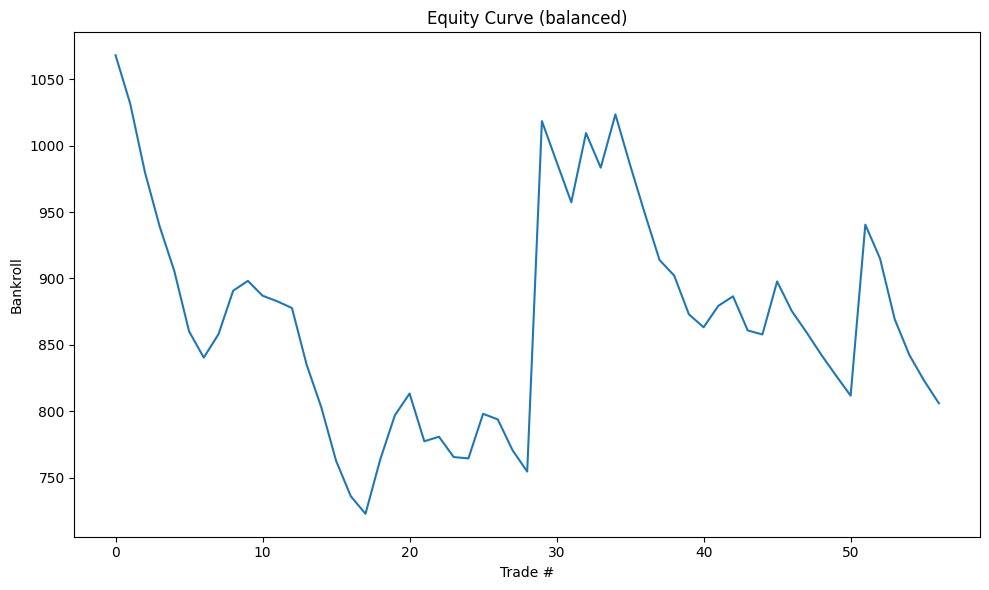

Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_equity_curve__balanced.png


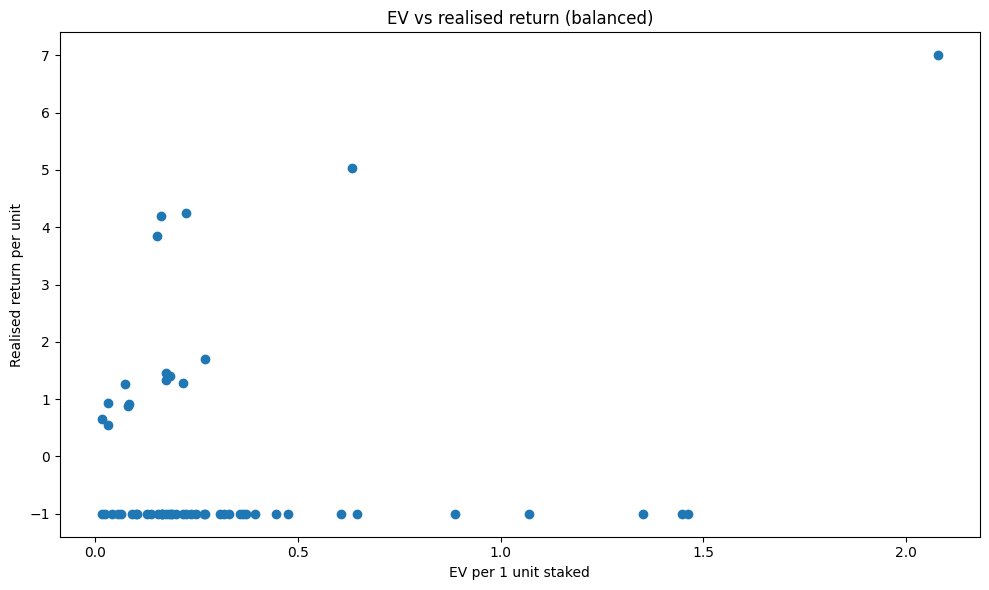

Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_ev_vs_realised__balanced.png

Calibration table — H


C:\Users\basti\AppData\Local\Temp\ipykernel_20868\2130852328.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(b)
C:\Users\basti\AppData\Local\Temp\ipykernel_20868\2130852328.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(b)
C:\Users\basti\AppData\Local\Temp\ipykernel_20868\2130852328.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(b)


,p_H,prob_mean,hit_rate,n
0,"(-0.001, 0.1]",0.070664,0.000000,2
1,"(0.1, 0.2]",0.106646,0.000000,2
2,"(0.2, 0.3]",0.230655,0.200000,5
3,"(0.3, 0.4]",0.370094,0.000000,4
4,"(0.4, 0.5]",0.452036,0.384615,13
5,"(0.5, 0.6]",0.535050,0.461538,13
6,"(0.6, 0.7]",0.652416,0.647059,17
7,"(0.7, 0.8]",0.701207,0.000000,1
8,"(0.8, 0.9]",NaN,NaN,0
9,"(0.9, 1.0]",NaN,NaN,0



Calibration table — D


,p_D,prob_mean,hit_rate,n
0,"(-0.001, 0.1]",NaN,NaN,0
1,"(0.1, 0.2]",0.194969,1.000000,1
2,"(0.2, 0.3]",0.253614,0.196078,51
3,"(0.3, 0.4]",0.338357,0.200000,5
4,"(0.4, 0.5]",NaN,NaN,0
5,"(0.5, 0.6]",NaN,NaN,0
6,"(0.6, 0.7]",NaN,NaN,0
7,"(0.7, 0.8]",NaN,NaN,0
8,"(0.8, 0.9]",NaN,NaN,0
9,"(0.9, 1.0]",NaN,NaN,0



Calibration table — A


,p_A,prob_mean,hit_rate,n
0,"(-0.001, 0.1]",0.080204,0.100000,10
1,"(0.1, 0.2]",0.145926,0.090909,11
2,"(0.2, 0.3]",0.251213,0.388889,18
3,"(0.3, 0.4]",0.334099,0.666667,9
4,"(0.4, 0.5]",0.466191,0.750000,4
5,"(0.5, 0.6]",0.553109,0.800000,5
6,"(0.6, 0.7]",NaN,NaN,0
7,"(0.7, 0.8]",NaN,NaN,0
8,"(0.8, 0.9]",NaN,NaN,0
9,"(0.9, 1.0]",NaN,NaN,0


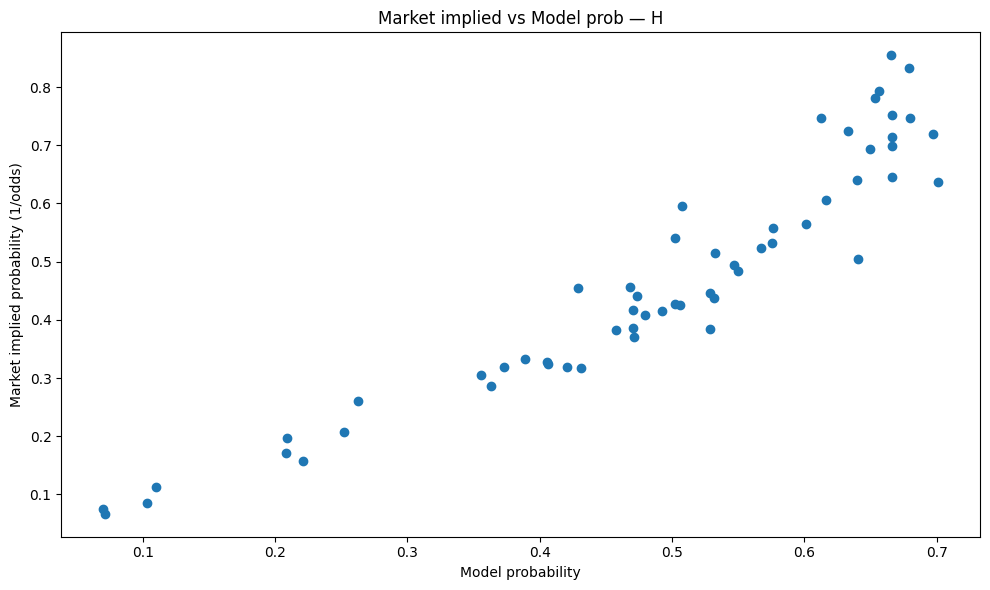

Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_market_vs_model_H__balanced.png


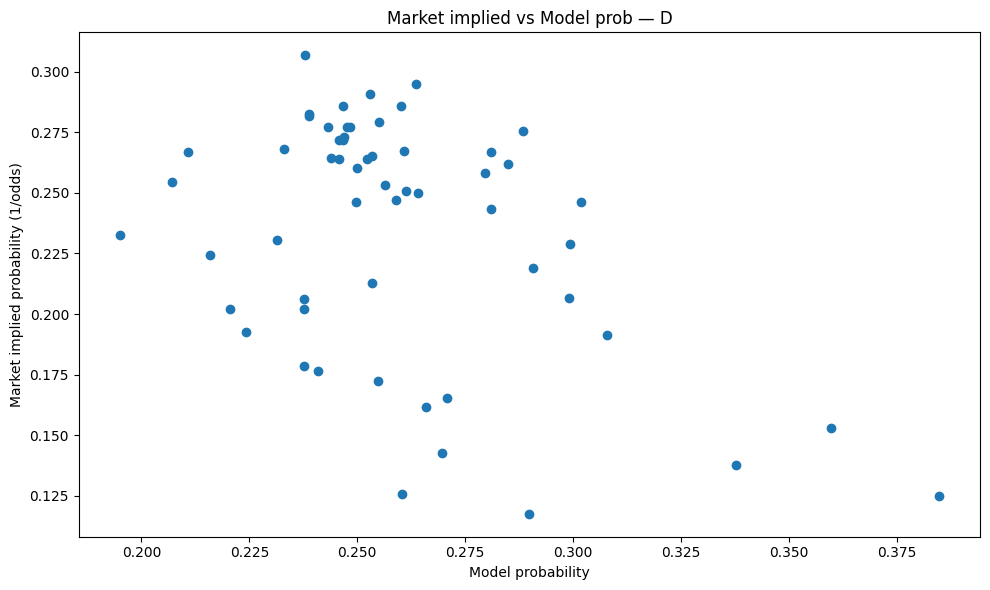

Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_market_vs_model_D__balanced.png


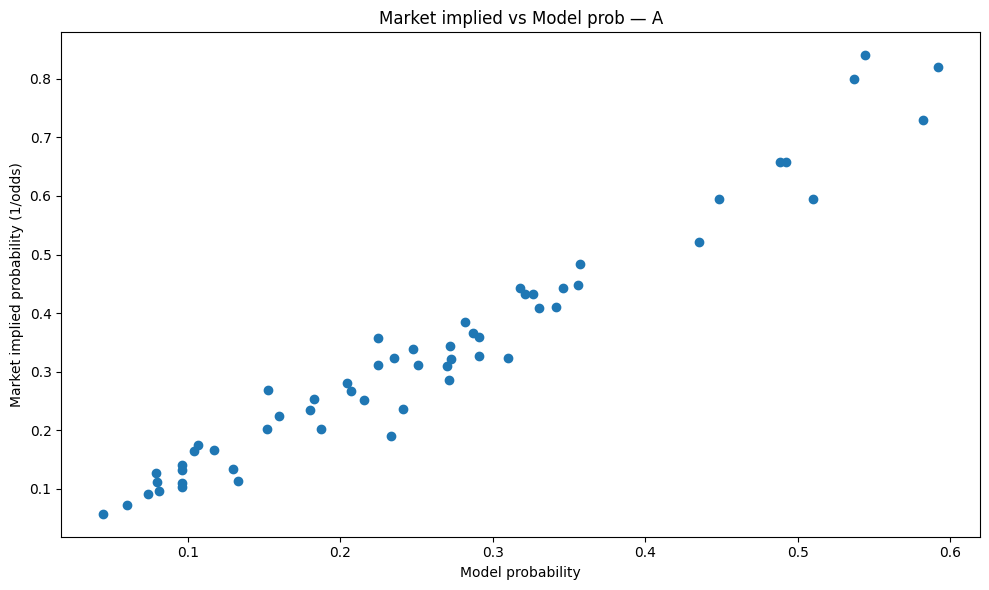

Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_market_vs_model_A__balanced.png


In [8]:
run_tag = PARAMS["RUN_TAG"]

# Equity curve
if not trade_log.empty:
    equity = cfg.initial_bankroll + trade_log["pnl"].cumsum()
    ax = equity.plot(title=f"Equity Curve ({run_tag})")
    ax.set_xlabel("Trade #")
    ax.set_ylabel("Bankroll")
    plt.tight_layout()
    eq_path = FIGURES_DIR / f"nb03_equity_curve__{run_tag}.png"
    plt.savefig(eq_path, dpi=200)
    plt.show()
    print("Saved:", eq_path)

# EV vs realised
if not trade_log.empty:
    plt.figure()
    plt.scatter(trade_log["ev"], trade_log["pnl"] / trade_log["stake"].replace(0, np.nan))
    plt.title(f"EV vs realised return ({run_tag})")
    plt.xlabel("EV per 1 unit staked")
    plt.ylabel("Realised return per unit")
    plt.tight_layout()
    ev_path = FIGURES_DIR / f"nb03_ev_vs_realised__{run_tag}.png"
    plt.savefig(ev_path, dpi=200)
    plt.show()
    print("Saved:", ev_path)

# Calibration-style bins for model probs vs hit rates
def bin_calibration(df_side_prob, df_side_hit, bins=np.linspace(0, 1, 11)):
    b = pd.cut(df_side_prob, bins, include_lowest=True)
    out = (
        pd.DataFrame({"prob": df_side_prob, "hit": df_side_hit})
        .groupby(b)
        .agg(prob_mean=("prob", "mean"), hit_rate=("hit", "mean"), n=("prob", "count"))
        .reset_index()
    )
    return out

cal_tables = {}
for s in ["H", "D", "A"]:
    prob = df[f"p_{s}"]
    hit = (df["outcome"] == s).astype(int)
    cal_tables[s] = bin_calibration(prob, hit)

for s, tab in cal_tables.items():
    print(f"\nCalibration table — {s}")
    display(tab)

# Scatter: market implied vs model probability
for s in ["H", "D", "A"]:
    plt.figure()
    plt.scatter(df[f"p_{s}"], 1.0 / df[f"odds_{s}"])
    plt.title(f"Market implied vs Model prob — {s}")
    plt.xlabel("Model probability")
    plt.ylabel("Market implied probability (1/odds)")
    plt.tight_layout()
    sc_path = FIGURES_DIR / f"nb03_market_vs_model_{s}__{run_tag}.png"
    plt.savefig(sc_path, dpi=200)
    plt.show()
    print("Saved:", sc_path)

## 9. Sensitivity Grid

In [9]:
def grid_search(df, initial_bankroll, ev_thresholds, kelly_fracs):
    rows = []
    for ev_th in ev_thresholds:
        for kf in kelly_fracs:
            cfg = SimConfig(
                initial_bankroll=initial_bankroll,
                allow_multi=False,
                staking="kelly",
                flat_unit=PARAMS["FLAT_UNIT"],
                kelly_fraction=kf,
                kelly_cap=PARAMS["KELLY_CAP"],
                ev_threshold=ev_th,
                max_bets_per_match=PARAMS["MAX_BETS_PER_MATCH"],
            )
            tr = simulate(df, cfg)
            summ = performance_summary(tr, initial_bankroll)
            summ.update({"ev_threshold": float(ev_th), "kelly_fraction": float(kf)})
            rows.append(summ)
    return pd.DataFrame(rows)

grid = grid_search(
    df,
    initial_bankroll=PARAMS["INITIAL_BANKROLL"],
    ev_thresholds=PARAMS["GRID_EV_THRESHOLDS"],
    kelly_fracs=PARAMS["GRID_KELLY_FRACS"],
)

display(grid.sort_values("roi_total", ascending=False).head(10))

grid_path = REPORTS_DIR / f"nb03_sensitivity_grid__{run_tag}.csv"
grid.to_csv(grid_path, index=False)
print("Saved:", grid_path)

,trades,roi_total,hit_rate,turnover,sharpe_like,max_drawdown_abs,max_drawdown_pct,ev_threshold,kelly_fraction
9,54,-0.025303,0.277778,0.604053,-0.469312,-158.944191,-0.154725,0.030000,0.100000
0,57,-0.026188,0.280702,0.608596,-0.663409,-158.944191,-0.154725,0.000000,0.100000
3,57,-0.026188,0.280702,0.608596,-0.663409,-158.944191,-0.154725,0.010000,0.100000
6,55,-0.027377,0.272727,0.605279,-0.622317,-158.944191,-0.154725,0.020000,0.100000
15,51,-0.030317,0.254902,0.591577,-0.566961,-161.818680,-0.157523,0.050000,0.100000
12,52,-0.031685,0.250000,0.592797,-0.724048,-161.818680,-0.157523,0.040000,0.100000
10,54,-0.192239,0.277778,1.312163,-0.469312,-345.522784,-0.323470,0.030000,0.250000
1,57,-0.194084,0.280702,1.321218,-0.663409,-345.522784,-0.323470,0.000000,0.250000
4,57,-0.194084,0.280702,1.321218,-0.663409,-345.522784,-0.323470,0.010000,0.250000
7,55,-0.196536,0.272727,1.312672,-0.622317,-345.522784,-0.323470,0.020000,0.250000


Saved: C:\Users\basti\Documents\football-betting\outputs\reports\nb03_sensitivity_grid__balanced.csv


## 10. Save main artefacts

In [10]:
run_tag = PARAMS["RUN_TAG"]

artifacts = {
    "trade_log": REPORTS_DIR / f"nb03_trade_log__{run_tag}.csv",
    "performance_summary": REPORTS_DIR / f"nb03_performance_summary__{run_tag}.json",
}

if not trade_log.empty:
    trade_log.to_csv(artifacts["trade_log"], index=False)

with open(artifacts["performance_summary"], "w") as f:
    json.dump(summary, f, indent=2, default=str)

print("Saved:")
for name, path in artifacts.items():
    print(" -", name, ":", path)
print("Figures saved in:", FIGURES_DIR.resolve())

Saved:
 - trade_log : C:\Users\basti\Documents\football-betting\outputs\reports\nb03_trade_log__balanced.csv
 - performance_summary : C:\Users\basti\Documents\football-betting\outputs\reports\nb03_performance_summary__balanced.json
Figures saved in: C:\Users\basti\Documents\football-betting\outputs\figures


## 11. Run all strategies and compare performance

In [11]:
all_results = []

def run_strategy(strategy_name):
    print("\n==============================")
    print(f" RUNNING STRATEGY: {strategy_name}")
    print("==============================")

    # Load preset
    if strategy_name not in PRESET_CONFIGS:
        raise ValueError(f"Unknown strategy '{strategy_name}'")

    PARAMS.update(PRESET_CONFIGS[strategy_name])
    PARAMS["RUN_TAG"] = strategy_name

    # Sync run_tag
    global run_tag
    run_tag = strategy_name

    # Rebuild config
    cfg = SimConfig(
        initial_bankroll=PARAMS["INITIAL_BANKROLL"],
        allow_multi=PARAMS["ALLOW_MULTI"],
        staking=PARAMS["STAKING"],
        flat_unit=PARAMS["FLAT_UNIT"],
        kelly_fraction=PARAMS["KELLY_FRACTION"],
        kelly_cap=PARAMS["KELLY_CAP"],
        ev_threshold=PARAMS["EV_THRESHOLD"],
        max_bets_per_match=PARAMS["MAX_BETS_PER_MATCH"],
    )

    # Run simulation
    trade_log = simulate(df, cfg)
    summary = performance_summary(trade_log, cfg.initial_bankroll)

    # Save trade log
    log_path = REPORTS_DIR / f"nb03_trade_log__{strategy_name}.csv"
    trade_log.to_csv(log_path, index=False)

    # Save summary JSON
    summary_path = REPORTS_DIR / f"nb03_summary__{strategy_name}.json"
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=2, default=str)

    # Plot equity curve
    if not trade_log.empty:
        equity = cfg.initial_bankroll + trade_log["pnl"].cumsum()
        plt.figure(figsize=(10, 6))
        plt.plot(equity)
        plt.title(f"Equity Curve — {strategy_name}")
        plt.xlabel("Trade #")
        plt.ylabel("Bankroll")
        plt.grid(True)
        fig_path = FIGURES_DIR / f"nb03_equity_curve__{strategy_name}.png"
        plt.savefig(fig_path, dpi=200)
        plt.close()
        print("Saved:", fig_path)

    # Keep results for comparison
    summary["strategy"] = strategy_name
    all_results.append(summary)


# --- Run all predefined strategies ---
for strat in ["conservative", "balanced", "aggressive"]:
    run_strategy(strat)

# Convert results to a comparison table
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[
    ["strategy", "trades", "roi_total", "hit_rate", "turnover",
     "sharpe_like", "max_drawdown_abs", "max_drawdown_pct"]
]

display(comparison_df)

# Save comparison to reports folder
comparison_path = REPORTS_DIR / "nb03_strategy_comparison.csv"
comparison_df.to_csv(comparison_path, index=False)
print("\nSaved comparison table to:", comparison_path)


 RUNNING STRATEGY: conservative
Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_equity_curve__conservative.png

 RUNNING STRATEGY: balanced
Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_equity_curve__balanced.png

 RUNNING STRATEGY: aggressive
Saved: C:\Users\basti\Documents\football-betting\outputs\figures\nb03_equity_curve__aggressive.png


,strategy,trades,roi_total,hit_rate,turnover,sharpe_like,max_drawdown_abs,max_drawdown_pct
0,conservative,57,-0.063479,0.280702,0.573023,-0.663409,-146.488438,-0.142600
1,balanced,57,-0.194084,0.280702,1.321218,-0.663409,-345.522784,-0.323470
2,aggressive,75,-0.406495,0.293333,2.334128,-0.378718,-628.445676,-0.553037



Saved comparison table to: C:\Users\basti\Documents\football-betting\outputs\reports\nb03_strategy_comparison.csv
